In [1]:
import os
from datetime import date, datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import kurtosis, skew
from scipy.signal import find_peaks

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

import ruptures as rpt

## Feature Extraction

In [2]:
def statistical_features(arr):
    vmin = np.amin(arr)
    vmax = np.amax(arr)
    mean = np.mean(arr)
    std = np.std(arr)
    return vmin, vmax, mean, std

def shape_features(arr):
    skewness = skew(arr)
    kurt = kurtosis(arr)
    return skewness, kurt

In [3]:
user = 'DF'

## Pre-processing

In [4]:
import_path = f'{user}'
export_path = f'{user}'

rightEDAdatapath  = f'{import_path}/EDA.csv'
rightHRdatapath   = f'{import_path}/HR.csv'
rightTEMPdatapath = f'{import_path}/TEMP.csv'

In [5]:
rightHRdatapath = np.loadtxt(rightHRdatapath, delimiter = ',')
rightHRdatapath = np.repeat(rightHRdatapath, 4)
np.savetxt('hr_new.csv', rightHRdatapath, delimiter = ',')

In [7]:
edat =  pd.read_csv(f'{user}/EDA.csv',  header = 2,  names = ['EDA'])
hrt =   pd.read_csv(f'hr_new.csv',      header = 12, names = ['HR'])
tempt = pd.read_csv(f'{user}/Temp.csv', header = 2,  names = ['TEMP'])
gt =    pd.read_csv(f'{user}/EDA.csv',  nrows  = 1)

In [8]:
reference_time = gt.iloc[0,0]
min_len = min(len(edat), len(hrt), len(tempt))

eda = edat.iloc[:min_len, 0]
hrt = hrt.iloc[:min_len, 0]
tempt = tempt.iloc[:min_len, 0]
df_original = pd.concat([eda, hrt, tempt], axis = 1)

In [9]:
array = df_original.values
data = pd.DataFrame(array)
data.columns = ['EDA','HR','temp']

cols = [
    'EDA_Mean','EDA_Min','EDA_Max','EDA_Std', 'EDA_Kurtosis', 'EDA_Skew','EDA_Num_Peaks','EDA_Amphitude','EDA_Duration',
    'HR_Mean','HR_Min','HR_Max','HR_Std','HR_RMS','temp_Mean', 'temp_Min','temp_Max','temp_Std'
]
df_features = pd.DataFrame(columns=cols)

index = 0

for i in range(0,len(data['EDA']), 20):
    df_partial = data.iloc[i:i+40,]
    plen = len(df_partial['EDA'])
    
    if plen < 40:
        continue
    
    eda = df_partial['EDA'].values
    hr = df_partial['HR'].values
    temp = df_partial['temp'].values

    eda_min, eda_max, eda_mean, eda_std = statistical_features(eda)
    hr_min, hr_max, hr_mean, hr_std = statistical_features(hr)
    temp_min, temp_max, temp_mean, temp_std = statistical_features(temp)
    eda_skew, eda_kurtosis = shape_features(eda)
    
    hr_rms = np.sqrt(np.mean(np.square(np.ediff1d(hr))))
    temp_rms= np.sqrt(np.mean(np.square(np.ediff1d(temp))))

    peaks,properties = find_peaks(eda, width=5)
    num_Peaks = len(peaks)
    
    prominences = np.array(properties['prominences'])
    widths = np.array(properties['widths'])
    amphitude = np.sum(prominences)
    duration = np.sum(widths)

    df_features.loc[index] = [eda_mean, eda_min, eda_max, eda_std, eda_kurtosis, eda_skew, num_Peaks, amphitude, duration, hr_mean, hr_min, hr_max, hr_std,hr_rms, temp_mean, temp_min, temp_max, temp_std]

    index = index+1

In [10]:
cols = list(map(str, range(30, 0, -1)))
df_lag_features = pd.DataFrame(columns=cols)
df_lag_features = pd.concat([
    df_features['HR_Mean'].shift(10),  df_features['HR_Mean'].shift(9),    df_features['HR_Mean'].shift(8),
    df_features['HR_Mean'].shift(7),   df_features['HR_Mean'].shift(6),    df_features['HR_Mean'].shift(5),
    df_features['HR_Mean'].shift(4),   df_features['HR_Mean'].shift(3),    df_features['HR_Mean'].shift(2),
    df_features['HR_Mean'].shift(1),   df_features['temp_Mean'].shift(10), df_features['temp_Mean'].shift(9),
    df_features['temp_Mean'].shift(8), df_features['temp_Mean'].shift(7),  df_features['temp_Mean'].shift(6),
    df_features['temp_Mean'].shift(5), df_features['temp_Mean'].shift(4),  df_features['temp_Mean'].shift(3),
    df_features['temp_Mean'].shift(2), df_features['temp_Mean'].shift(1),  df_features['EDA_Mean'].shift(10),
    df_features['EDA_Mean'].shift(9),  df_features['EDA_Mean'].shift(8),   df_features['EDA_Mean'].shift(7),
    df_features['EDA_Mean'].shift(6),  df_features['EDA_Mean'].shift(5),   df_features['EDA_Mean'].shift(4),
    df_features['EDA_Mean'].shift(3),  df_features['EDA_Mean'].shift(2),   df_features['EDA_Mean'].shift(1)], axis=1)
df_lag_features.columns = cols
df_lag_features = df_lag_features.dropna()

In [11]:
df_temp = df_features.iloc[30:3238, 0:31]
df_total = pd.concat([df_lag_features, df_temp], axis=1)

## Stress detection model

In [12]:
df_lag = pd.read_csv('combined_lagEDA.csv')
train_set = df_lag.iloc[:,0:48]
labels = df_lag.iloc[:,48:49]

#Crear un clasificador de bosque aleatorio
clf = RandomForestClassifier(n_estimators=100,max_depth=15)

# Dividir nuestros datos
train, test, train_labels, test_labels = train_test_split(train_set, labels, test_size=0.33, random_state=30)

#Entrena el modelo usando los conjuntos de entrenamiento y_pred=clf.predict(X_test)
clf.fit(train, train_labels.values.ravel())

y_pred = clf.predict(test)

f1score   = f1_score        (test_labels, y_pred, average = 'macro')
recall    = recall_score    (test_labels, y_pred, average = 'macro')
precision = precision_score (test_labels, y_pred, average = 'macro')
accuracy  = accuracy_score  (test_labels, y_pred)

print('acc =', accuracy)
print('pre =', precision)
print('recall =', recall) 
print('f1 =', f1score)

acc = 0.9520331141952764
pre = 0.9518549562134799
recall = 0.932005185930923
f1 = 0.9406174182636219


### Predicting the stress

In [13]:
df_total = df_total.dropna()
scalar = MinMaxScaler()
x_scaled = scalar.fit_transform(df_total.iloc[:,0:48])
data = pd.DataFrame(x_scaled)
data = data.fillna(0)

pred_t = clf.predict(data)
pred_t = pd.DataFrame(pred_t)
pred_t.columns=['pred']
pred_t.head(30)
pred_t.to_csv('pred'+user+'.csv')

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [14]:
df_total['pred'] = pred_t
df_total.to_csv('pred{user}.csv')

In [15]:
df_total['MA_3'] = np.ceil(df_total.iloc[:,48:49].rolling(window=31).mean())

### Change detection

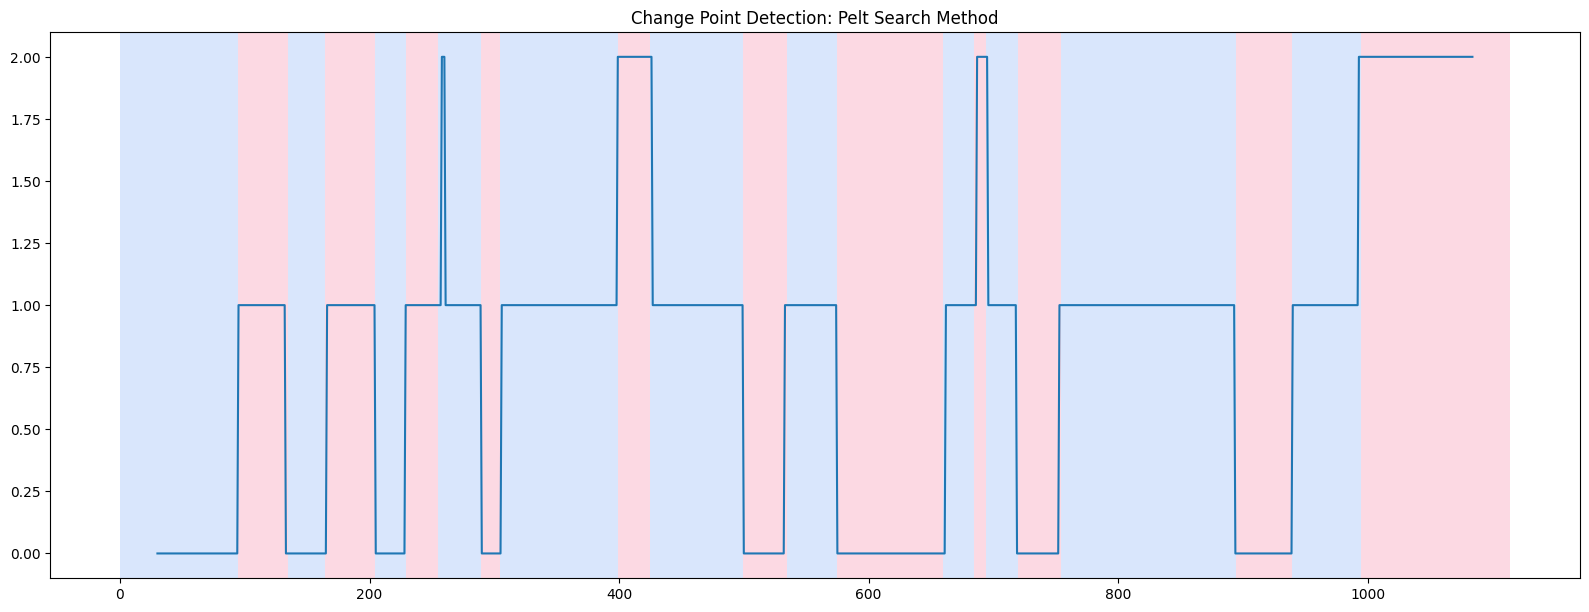

[0, 95, 135, 165, 205, 230, 255, 290, 305, 400, 425, 500, 535, 575, 660, 685, 695, 720, 755, 895, 940, 995, 1115]


In [16]:
signal = df_total.iloc[:,49:50].values

algo = rpt.Window(model="l2", width=10).fit(signal)
result = algo.predict(n_bkps=60)

rpt.display(signal, result, figsize=(16, 6))
plt.title('Change Point Detection: Pelt Search Method')
plt.show()

result.insert(0, 0)
print(result)

### Generating the event by start and end epoch_times

In [17]:
temp_start = 0
temp_end = result[0]

stress = []
for i in range (len(result)-1):
    
    temp = df_total.iloc[result[i]:(result[i+1]-1), 49:50].mean()[0]
    
    if temp > 1.3:
        temp = 2.0
    elif temp >= .65:
        temp = 1
    else:
        temp = 0

    stress.append(temp)
    
df_temp = pd.DataFrame(columns=['start', 'end', 'stress'])
c = 0
for i in range(len(result)-1):
    stressLength = (result[i+1] - result[i]) / 12

    start_point  = result[i]
    end_point    = result[i + 1]
    stress_value = stress[i]
    
    if temp_end <= start_point:
        temp_end       = end_point
        df_temp.loc[c] = [start_point, end_point, stress_value]
        c = c +1

df_temp

,start,end,stress
0,0.0,95.0,0.0
1,95.0,135.0,1.0
2,135.0,165.0,0.0
3,165.0,205.0,1.0
4,205.0,230.0,0.0
5,230.0,255.0,1.0
6,255.0,290.0,1.0
7,290.0,305.0,0.0
8,305.0,400.0,1.0
9,400.0,425.0,2.0


## Change event time to datetime

In [18]:
stress_start = 0
stress_end = 0
tse = 0
previous_stress = -1

for index, row in df_temp.iterrows():

    if row['stress'] == previous_stress:
        stress_end = row['end']
    else:
        if(previous_stress != -1):
            start    = datetime.fromtimestamp(reference_time + (stress_start * 5))
            end      = datetime.fromtimestamp(reference_time + (stress_end * 5))
            timediff = end - start
            print('Prev:', timediff, datetime.fromtimestamp(reference_time + (stress_start * 5)).strftime('%H:%M:%S'), datetime.fromtimestamp(reference_time + (stress_end * 5)).strftime('%H:%M:%S'), previous_stress)
        
        stress_start    = row['start']
        stress_end      = row['end']
        previous_stress = row['stress']
        
print('Final:', timediff, datetime.fromtimestamp(reference_time + (stress_start * 5)).strftime('%H:%M:%S'), datetime.fromtimestamp(reference_time + (stress_end * 5)).strftime('%H:%M:%S'), previous_stress)

Prev: 0:07:55 19:00:04 19:07:59 0.0
Prev: 0:03:20 19:07:59 19:11:19 1.0
Prev: 0:02:30 19:11:19 19:13:49 0.0
Prev: 0:03:20 19:13:49 19:17:09 1.0
Prev: 0:02:05 19:17:09 19:19:14 0.0
Prev: 0:05:00 19:19:14 19:24:14 1.0
Prev: 0:01:15 19:24:14 19:25:29 0.0
Prev: 0:07:55 19:25:29 19:33:24 1.0
Prev: 0:02:05 19:33:24 19:35:29 2.0
Prev: 0:06:15 19:35:29 19:41:44 1.0
Prev: 0:02:55 19:41:44 19:44:39 0.0
Prev: 0:03:20 19:44:39 19:47:59 1.0
Prev: 0:07:05 19:47:59 19:55:04 0.0
Prev: 0:02:05 19:55:04 19:57:09 1.0
Prev: 0:00:50 19:57:09 19:57:59 2.0
Prev: 0:02:05 19:57:59 20:00:04 1.0
Prev: 0:02:55 20:00:04 20:02:59 0.0
Prev: 0:11:40 20:02:59 20:14:39 1.0
Prev: 0:03:45 20:14:39 20:18:24 0.0
Prev: 0:04:35 20:18:24 20:22:59 1.0
Final: 0:04:35 20:22:59 20:32:59 2.0
